In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, random
from keras import layers, losses, metrics
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
# Checking dataframe
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
# Checking descriptive statistics
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [5]:
# Looking up general info about the data, such as number of entries, feature names, null values, and Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
# Checking shape
df.shape

(9912, 14)

In [7]:
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (128, 128), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

In [8]:
X = np.array(images).reshape(-1,128,128,3) / 255
X.shape

(9912, 128, 128, 3)

In [9]:
y = df['Pawpularity']
y.shape

(9912,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
def image_read(path):
    return cv2.imread(path)

df['path'] = df.apply(lambda x : 'data/train/' + x['Id'] + ".jpg", axis=1)

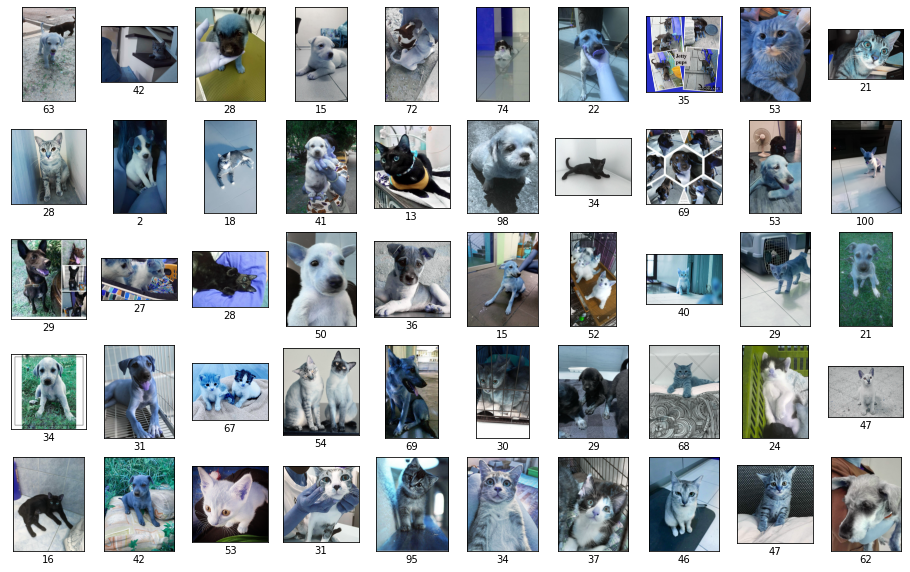

In [13]:
# Plot first 50 images
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(df[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

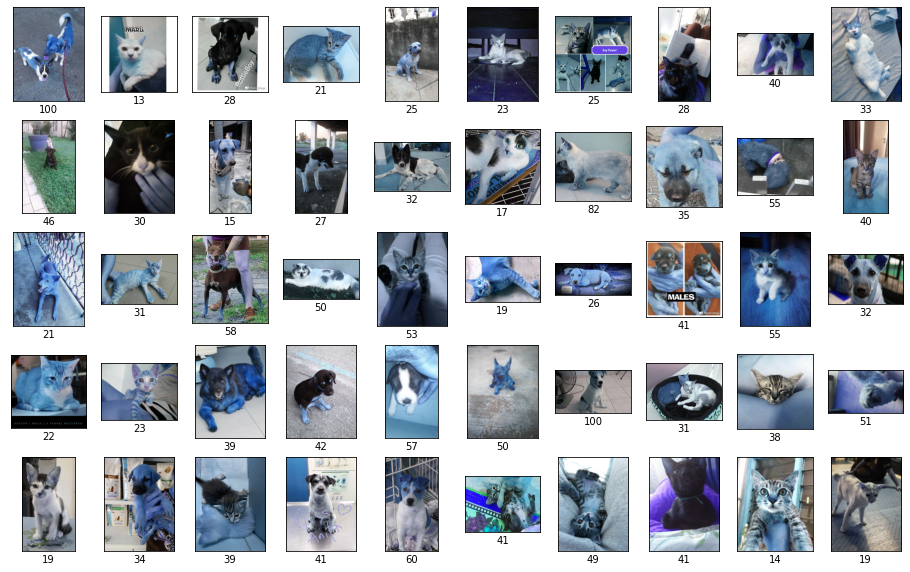

In [14]:
# Plot next 50 images
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(df[['path', 'Pawpularity']][50:100].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

## Baseline Artificial Neural Network

In [ ]:
ann = Sequential([
        layers.Flatten(),
        layers.Dense(1000, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

ann.compile(optimizer='SGD',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

ann.fit(X_train, y_train, epochs=5)

In [16]:
cnn1 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='relu')
      ])

cnn1.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn1.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 140s 600ms/step - loss: 649.6702 - root_mean_squared_error: 25.4886
Epoch 2/10
233/233 [==============================] - 150s 645ms/step - loss: 569.3075 - root_mean_squared_error: 23.8602
Epoch 3/10
233/233 [==============================] - 161s 690ms/step - loss: 568.1352 - root_mean_squared_error: 23.8356
Epoch 4/10
233/233 [==============================] - 175s 751ms/step - loss: 568.4609 - root_mean_squared_error: 23.8424
Epoch 5/10
233/233 [==============================] - 221s 947ms/step - loss: 567.2064 - root_mean_squared_error: 23.8161
Epoch 6/10
233/233 [==============================] - 227s 976ms/step - loss: 566.8851 - root_mean_squared_error: 23.8093
Epoch 7/10
233/233 [==============================] - 209s 895ms/step - loss: 565.8472 - root_mean_squared_error: 23.7875
Epoch 8/10
233/233 [==============================] - 185s 795ms/step - loss: 565.1252 - root_mean_squared_error: 23.7724
Epoch 9/10
233/233 [====

In [17]:
cnn2 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu')
      ])

cnn2.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn2.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 108s 466ms/step - loss: 947.9289 - root_mean_squared_error: 30.7884
Epoch 2/10
233/233 [==============================] - 115s 492ms/step - loss: 905.7529 - root_mean_squared_error: 30.0957
Epoch 3/10
233/233 [==============================] - 97s 417ms/step - loss: 906.6743 - root_mean_squared_error: 30.1110
Epoch 4/10
233/233 [==============================] - 96s 414ms/step - loss: 903.7504 - root_mean_squared_error: 30.0624
Epoch 5/10
233/233 [==============================] - 97s 418ms/step - loss: 903.6597 - root_mean_squared_error: 30.0609
Epoch 6/10
233/233 [==============================] - 95s 409ms/step - loss: 902.4834 - root_mean_squared_error: 30.0414
Epoch 7/10
233/233 [==============================] - 94s 401ms/step - loss: 901.7820 - root_mean_squared_error: 30.0297
Epoch 8/10
233/233 [==============================] - 94s 403ms/step - loss: 902.4567 - root_mean_squared_error: 30.0409
Epoch 9/10
233/233 [==========

In [18]:
cnn3 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear')
      ])

cnn3.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn3.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 276s 1s/step - loss: 502.3515 - root_mean_squared_error: 22.4132
Epoch 2/10
233/233 [==============================] - 228s 979ms/step - loss: 430.2822 - root_mean_squared_error: 20.7432
Epoch 3/10
233/233 [==============================] - 307s 1s/step - loss: 425.2588 - root_mean_squared_error: 20.6218
Epoch 4/10
233/233 [==============================] - 263s 1s/step - loss: 425.3193 - root_mean_squared_error: 20.6233
Epoch 5/10
233/233 [==============================] - 318s 1s/step - loss: 425.4178 - root_mean_squared_error: 20.6257
Epoch 6/10
233/233 [==============================] - 272s 1s/step - loss: 424.3543 - root_mean_squared_error: 20.5999
Epoch 7/10
233/233 [==============================] - 296s 1s/step - loss: 424.2745 - root_mean_squared_error: 20.5979
Epoch 8/10
233/233 [==============================] - 208s 892ms/step - loss: 426.0494 - root_mean_squared_error: 20.6410
Epoch 9/10
233/233 [======================

In [19]:
cnn3.evaluate(X_test, y_test)

78/78 [==============================] - 14s 177ms/step - loss: 449.0496 - root_mean_squared_error: 21.1908


[449.04962158203125, 21.1907901763916]

In [ ]:
cnn4 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear'),
        layers.Dropout(0.5)
      ])

cnn4.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn4.fit(X_train, y_train, epochs=10)

In [ ]:
cnn5 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear')
      ])

cnn5.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn5.fit(X_train, y_train, epochs=50)

In [ ]:
cnn6 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='relu')
      ])

cnn6.compile(optimizer='adam',
             loss=losses.MeanSquaredError(),
             metrics=[metrics.RootMeanSquaredError()])

cnn6.fit(X_train, y_train, epochs=5)